In [1]:
from dataloader import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 as cv # so annoying in tutorials ngl
import random
%matplotlib qt
import pickle as pkl
from skimage import data, feature, exposure
import pytesseract
from docx import Document
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import multiprocessing as mp
import string
import nltk
import edit_distance
import torch
from dataloader import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 as cv # so annoying in tutorials ngl
import random
from skimage import data, feature, exposure
import pytesseract
from docx import Document
import pickle as pkl
import multiprocessing as mp
from mmocr.utils.ocr import MMOCR
import pytesseract
from sklearn.mixture import GaussianMixture
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import pipeline, set_seed
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [2]:
files = DataAnuncis('/home/adri/Desktop/cvc/data/tinder-historic/filenames.txt')
OCR = MMOCR(recog='Tesseract')

load checkpoint from http path: https://download.openmmlab.com/mmocr/textdet/panet/panet_r18_fpem_ffm_sbn_600e_icdar2015_20210219-42dbe46a.pth


In [3]:
def corner_detector(sample):
    ret, thresh = cv2.threshold(sample, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    dst = cv.cornerHarris(thresh,10,3,0.04)
    #ret, thresh = cv2.threshold(dst, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    dst = (dst - dst.min()) / (dst.max() - dst.min()) * 255
    ret, thresh = cv2.threshold(dst.astype(np.uint8), 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    thresh = ~thresh
    conv_kernel = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]])
    kernel = conv_kernel
    kernel2 = kernel.T
    convolved = cv2.filter2D(thresh, -1, kernel = kernel) + cv2.filter2D(thresh, -1, kernel = kernel2)
    
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(convolved)


    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)

    output = np.zeros_like(sample).copy()
    outputFilled = np.zeros_like(sample).copy()

    boxes = []
    for i in range(0, num_labels):

        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        if h*w < 1000 or h*w > 0.9*sample.shape[-1] * sample.shape[-2]: continue
        
        
        outputFilled = cv2.rectangle(outputFilled, (x, y), (x + w, y + h), ((255, 255, 255)), -1)
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 255, 255), 10)
        
        boxes.append((x, y, w, h))
    
    ### CONVEX HULL ###
    ret = cv.findContours((outputFilled).astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    drawing = np.zeros_like(sample).copy()

    color = (random.randint(50,255), random.randint(50,255), random.randint(50,255))
    
    return output, labeled_img, boxes, convolved, outputFilled

    

In [4]:
def visualize_sample(index, files = files):
    o, i, bbxs, c, filled = corner_detector(files[index][0])
    fig, axs = plt.subplots(1, 4, figsize = ( 32, 8 ))
    
    axs[3].imshow(files[index]*.5 + filled*.5, cmap = 'gray')
    axs[3].axis('off')
    
    axs[2].imshow(i.astype(np.uint8)/255 * 0.3 + np.stack((o, o, o)).transpose(1, 2, 0)/255 * 0.7)
    axs[2].axis('off')

    axs[1].imshow(c, cmap = 'gray')
    axs[1].axis('off')

    axs[0].imshow(files[index], cmap = 'gray')
    axs[0].axis('off')

    plt.show()

def extract_boxes(img, filled_image):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(filled_image)
    boxes = []
    output = np.zeros_like(img).copy()
    for i in range(0, num_labels):

        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        if h*w > 0.8*img.shape[-1] * img.shape[-2]: continue
        
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 255, 255), 10)
        boxes.append(img[y:y+h, x:x+w])
        
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)
        
    return boxes, output, labeled_img

In [5]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def get_string(bbx):
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 2))
    ret, bbx = cv2.threshold(bbx, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    dilation = cv2.dilate(bbx, rect_kernel, iterations = 1)
    
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    total = ''    
    for cnt in contours[::-1]:
        x, y, w, h = cv2.boundingRect(cnt)
        # Cropping the text block for giving input to OCR
        cropped = bbx[y:y + h, x:x + w]

        
        crop = np.stack([cropped, cropped, cropped])
        
        
        pixel_values = processor(images=crop, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        string = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        
        total += string + ' '

            
    
    return total 


In [7]:
sample = files[1]
o, labeled, boxes, conv, filled = corner_detector(sample[0])

In [8]:
bbxs, o, labeled = extract_boxes(sample[0], filled)    

In [9]:
box = bbxs[140]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


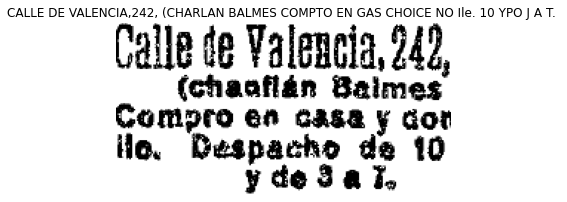

In [10]:
%matplotlib inline
plt.imshow(box, cmap = 'gray')
plt.axis('off')
plt.title(get_string(box))
plt.show()

In [11]:
bbxs[0].shape

(23, 95)

In [ ]:
%matplotlib qt
plt.imshow(filled)
plt.show()